<a href="https://colab.research.google.com/github/cu-applied-math/appm-4600-numerics/blob/lab_solutions/Labs/Lab10_FFT_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 10: The (2D) DFT/FFT and Image compression (SOLUTIONS)

### Learning objectives
- Gain familiarity with Fourier Series and the 1D and 2D DFT
  - Along the way, see some similarities and differences with "Fourier series" vs the "Discrete Fourier Transform"
- Witness the [Gibbs phenomenon](https://en.wikipedia.org/wiki/Gibbs_phenomenon) and be able to describe it
  - Since we're talking about convergence of *functions* $p_n \to f$, there are different modes of convergence, e.g., pointwise, uniform/$L^\infty$, quadratic-mean/$L^2$. Understand which mode of convergence the Gibbs phenomenon affects.
- Understand how smoothness of a signal/function $f$ relates to the decay of its Fourier coefficients (in either Fourier series or DFT)
  - and how this relates to assumptions of periodicity
- See how we can exploit signals/images that have fast decaying Fourier coefficients by truncating their Fourier coefficients (i.e., setting some coefficients to zero)
  - In particular, this gives a rudimentary form of lossy compression

### Tasks
There are 4 components to this lab:
1. Fourier Series and the Gibbs phenomenon
    - This is the main required part of the lab, and related to the deliverables
2. 2D DFT and image compression
    - The very first part of this has a deliverable
    - The rest of this is designed to be more fun. You choose your own image and see what happens if you only "keep" certain Fourier coefficients (i.e., just the low frequencies)
3. (Optional) Looks at the relative importance of magnitude and phase in the DFT coefficients
    - There is no "todo" here, just follow along
4. (Optional) Examine the speed of the FFT
    - There is no "todo" here, just follow along

### Deliverables
A PDF with the following:
- The 2 plots and one or two sentences from Part 1 on the Gibbs phenomenon
- The ratio of file sizes from Part 2 on image formats


APPM 4600. Copyright Department of Applied Mathematics, University of Colorado Boulder. Released under a BSD 3-clause license

In [ ]:
import numpy as np
from numpy.linalg import norm
from matplotlib import pyplot as plt
import requests
from io import BytesIO
import os
import glob
import numpy.fft as fft
# import scipy.fft as fft # also fine, has a bit more functionality. Documentation:
# https://docs.scipy.org/doc/scipy/reference/fft.html#module-scipy.fft
# https://docs.scipy.org/doc/scipy/tutorial/fft.html

## Part 1: Fourier Series and the Gibbs phenomenon

On any domain of length $2\pi$ (e.g., $[-\pi,\pi]$), write
$$f(x)=a_0 + \sum_{k=1}^\infty a_k \cos(kx) + b_k\sin(kx)$$
and we'll find $a_k,b_k$ using orthogonality:
$$a_k = \frac{1}{\pi}\int_{-\pi}^\pi f(x) \cos(kx)\,dx$$
and
$$b_k = \frac{1}{\pi}\int_{-\pi}^\pi f(x) \sin(kx)\,dx.$$

Let's look at the simplest **discontinuous** function $f$ that we can think of:
$$f(x) = \begin{cases} 1 & |x| \le \pi/2 \\ 0 & |x| > \pi/2\end{cases}$$
so then
$$b_k=0$$
via symmetry (since $f$ is even and $\sin$ is odd), and $a_0=\pi\frac{1}{2\pi}=\frac12$ and
$$a_k = \frac{1}{\pi}\int_{-\pi/2}^{\pi/2}  \cos(kx)\,dx = \frac{1}{\pi}\frac{1}{k}\sin(kx)\Big|_{-\pi/2}^{\pi/2}=\frac{1}{\pi}\frac{2}{k}\sin\left(\frac{k\pi}{2}\right)$$
and $\sin(k\pi/2)$ is $1,0,-1,0,1,0,-1,0,\ldots$ for $k=1,2,3,4,\ldots$.

Define
$$p_n(x) = a_0 + \sum_{k=1}^n a_k \cos(kx) + b_k\sin(kx)$$
using these coefficients. Then $\lim_{n\to\infty}\|f-p_n\|_{L^2} = 0$ but does $\lim_{n\to\infty}\|f-p_n\|_{L^\infty} = 0$? i.e., does $p_n$ converge to $f$ *uniformly* on the interval?  (Recall $\|f\|_{L^\infty} = \max_{x\in I} |f(x)|$ for a continuous function over an interval $I$).

**Task**
- Create a function `p(x,n)` that evaluates $p_n(x)$
- Plot $f$ and $p_n(x)$ (for $n=50$, though you may also experiment with other values of $n$ first)
- For a given $n$, estimate $\|f-p_n\|_{L^2}=\sqrt{ \int_{-\pi}^\pi (f(x)-p_n(x))^2\,dx}$.
  - *For our purposes, just make a finely spaced grid of $m\approx 500$ points and approximate this integral with a sum*
- For a given $n$, estimate $\|f-p_n\|_{L^\infty} = \max_{x\in[-\pi,\pi]}\, |f(x)-p_n(x)|$.
  - *Again, you can approximate this with a finely spaced grid of points. However, be careful with this: as $n$ increases, we need more and more finely spaced points or else we might miss the location where we have the max (see the plot you made). My suggestion is to choose $m\approx 500$ grid points only in the region $[\pi/2 - \frac{1}{n}, \pi/2 + \frac{1}{n}]$ since we know (from the plot) that this is the region where the difference is greatest.*

**Deliverables**
- A plot of $f$ and $p_n(x)$ for $n=50$
- A plot of (estimates of) both $\|f-p_n\|_{L^2}$ and $\|f-p_n\|_{L^\infty}$ as function of $n$, for 10 values of $n$ between 10 and 500. *You should decide if you want to make any of the axes logarithmically scaled*
- A sentence or two describing about your findings

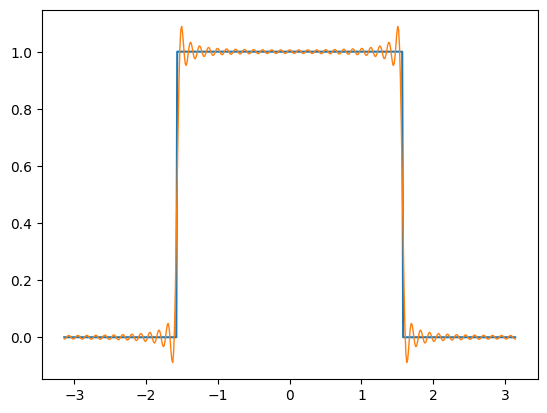

In [ ]:
a, b = -np.pi, np.pi

f = lambda x : np.where( np.abs(x) < np.pi/2, 1, 0 )

def p(x,n):
    """ the first n terms of the Fourier series """
    y = .5*np.ones_like(x) # the a_0 term
    for k in range(1,n+1, 2):
        y += (-1)**((k-1)/2)*np.cos(k*x)*2/(k*np.pi)
    return y

xGrid = np.linspace(a, b, 500)
yGrid = f(xGrid)

plt.plot(xGrid, f(xGrid) )
plt.plot(xGrid, p(xGrid, 50), '-',linewidth=1 )
plt.show()

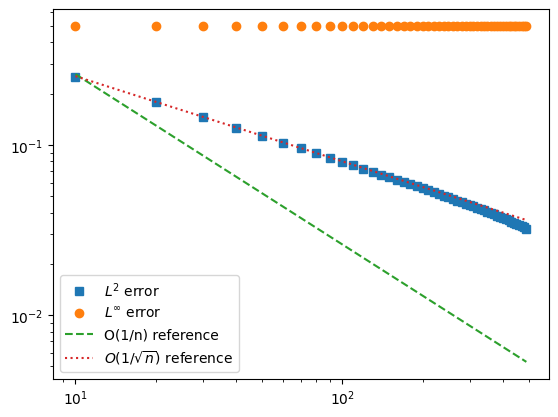

In [ ]:
nList = np.arange(10,500,10,dtype=int)
err_L2, err_Linf = [], []
for n in nList:
    xGrid = np.linspace(a,b,1000)
    dx    = xGrid[1]-xGrid[0]
    err_L2.append( np.sqrt(dx*np.sum((f(xGrid)-p(xGrid,n))**2)) )

    # for finding the linf error, we have to be more careful
    xGrid = np.linspace(np.pi/2 - 1/n, np.pi/2 + 1/n, 1000)
    # err_Linf.append( np.max(np.abs(f(xGrid)-p(xGrid,n))) )
    err_Linf.append( norm(f(xGrid)-p(xGrid,n), np.inf) )

plt.loglog(nList,err_L2, 's',label='$L^2$ error')
plt.loglog(nList,err_Linf, 'o',label=r'$L^\infty$ error')
plt.loglog(nList,2.6/nList, '--',label=r'O(1/n) reference')
plt.loglog(nList,.8/np.sqrt(nList), ':',label=r'$O(1/\sqrt{n})$ reference')
plt.legend()
plt.show()

**SOLUTION** Findings: we see that as $n\to\infty$, the $L^2$ error converges to $0$ (at rate about $1/\sqrt{n}$), but the $L^\infty$ error does not.

This is an example of the Gibbs phenomenon.  Other than at the points of discontinuities, it *is* true that $p_n(x) \to f(x)$, i.e., we have pointwise convergence. But it's not uniform! If it were uniform, it means $\forall \epsilon>0$, $\exists N$ such that $n\ge N$ implies $(\forall x\in[-\pi/pi])$ that $|f(x)-p_n(x)|<\epsilon$.  What we have instead is pointwise *non-uniform* convergence, meaning that the "$N$" depends on which point $x$ we are asking about!

## Part 2: DFT/FFT

### Warmup: get acquainted with the 1D FFT
No work on your part required, just look at the code below to start getting familiar with working with the FFT/DFT

Frequencies, in default ordering, are: [ 0.          0.15151515  0.3030303   0.45454545  0.60606061  0.75757576
 -0.75757576 -0.60606061 -0.45454545 -0.3030303  -0.15151515]
Frequencies, in shifted ordering, are: [-0.75757576 -0.60606061 -0.45454545 -0.3030303  -0.15151515  0.
  0.15151515  0.3030303   0.45454545  0.60606061  0.75757576]


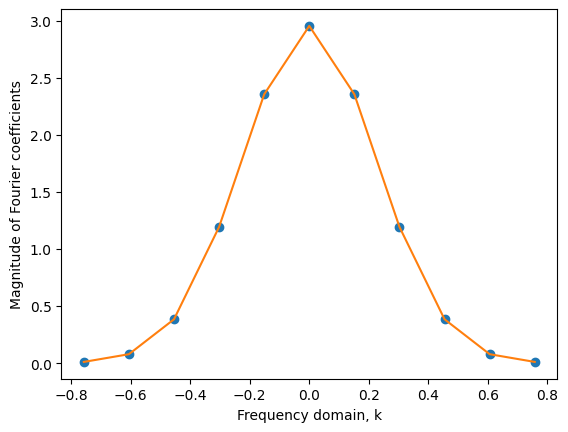

In [ ]:
# Pick a domain
a, b = -3, 3  # need not be 0, 2*np.pi

# Pick a function
f = lambda x : np.exp(-x**2)

n = 11 # this is like N ( = 2n+1 ) in the lecture notes
x = np.linspace(a, b, n)
dx = x[1] - x[0]
y = f(x)

# plt.plot(x, y)
# plt.xlabel('Original domain (e.g., space or time)')
# plt.show()

freqs = fft.fftfreq(n, d=dx)
print("Frequencies, in default ordering, are:", freqs)
print("Frequencies, in shifted ordering, are:", fft.fftshift(freqs))

yhat = fft.fft(y)
plt.plot( freqs, np.abs(yhat), 'o' ) # Ok, but if you draw a line between the points it looks funny
plt.plot( fft.fftshift(freqs), np.abs(fft.fftshift(yhat)), '-' ) # should look better
plt.xlabel('Frequency domain, k')
plt.ylabel('Magnitude of Fourier coefficients')
plt.show()

What if we set some Fourier coefficients to zero? i.e., only keep the large ones?

Then we can't expect to *interpolate*, but maybe we still have reasonable approximation?

Should this depend on the smoothness of the function?

(*still no work on your part required yet*)

/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1709: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/usr/local/lib/python3.12/dist-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


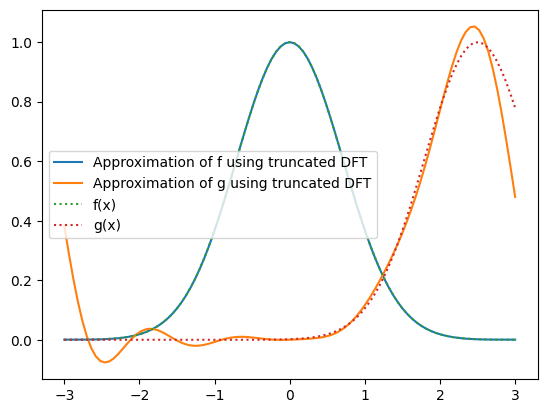

In [ ]:
# Pick a domain
a, b = -3, 3  # need not be 0, 2*np.pi

# Pick a nice, "smooth" function... but it's not really that smooth since derivatives don't match at boundaries
f = lambda x : np.exp(-x**2)
# And another function that isn't periodic on this domain -- even less smooth!
g = lambda x : np.exp(-(x-2.5)**2)

n = 101
x = np.linspace(a, b, n)
dx = x[1] - x[0]
y1 = f(x)
y2 = g(x)

# Take Fourier transforms
y1hat = fft.fft(y1)
y2hat = fft.fft(y2)

m = 10 # number of Fourier terms to keep. If n is even, m should be odd
def keep_only_largest_terms( yhat, m ):
    '''keeps only the m largest terms of yhat (in abs value),
    changing yhat in-place. This has side-effects! '''
    if len(yhat) % 2 == m % 2:
        raise ValueError('length(yhat) and m should be even/odd or odd/even')
    indx = np.argpartition( np.abs(yhat), m)
    yhat[indx[:n-m]] = 0 # set these to zero
    return yhat

ifft = lambda yhat : np.real_if_close(fft.ifft(yhat))

# Keep only the largest m terms of the Fourier transform (set rest to zero)
y1hat = keep_only_largest_terms(y1hat, m)
y2hat = keep_only_largest_terms(y2hat, m)

# Transform back with inverse FFT (ifft)
y1_est = ifft(y1hat)
y2_est = ifft(y2hat)

plt.plot(x, y1_est, '-',label='Approximation of f using truncated DFT')
plt.plot(x, y2_est, '-',label='Approximation of g using truncated DFT')
plt.plot(x,y1,':',label='f(x)')
plt.plot(x,y2,':',label='g(x)')
plt.legend()
plt.show()

What do we see?  Both $f$ and $g$ appear to be smooth, but $f$ is only continuous (i.e., its derivative is not continuous, since $f'(-\pi) \neq f'(\pi)$), and $g$ isn't even continuous (it *looks* continuous, but its **periodic extension** isn't).

### Main task for part 2: 2D DFT
We'll apply the 2D DFT/FFT to images

We didn't discuss this in depth in class, so we won't go much into the math of the extension to 2D but for rectangular grids it is straightforward, and numpy/scipy have `fft2` functions (and their inverses) that do everything we need.

The plan is to explore the 2D DFT in the context of images (which are 2D).

#### Short background on image formats
Images have a lot of structure (you wouldn't call a picture of random noise an "image"), and it is an empirical fact that the 2D DFT coefficients of images tend to decay quickly.
  - The "wavelet" coefficients of images also have nice decay properties, and are less sensitive to global effects from sharp edges, and have been used in image standards like [JPEG2000](https://en.wikipedia.org/wiki/JPEG_2000) though that never really caught on

As you're probably aware, there are many different formats to store images. Some popular ones include:
- [JPEG](https://en.wikipedia.org/wiki/JPEG), which does **lossy compression** meaning that it can make a small file but it's not an exact replica of the original data.  Videos use lossy compression (otherwise they would be gigantic!)JPEG can also do lossless compression on top of the lossy compression.
- [PNG](https://en.wikipedia.org/wiki/PNG), which can do [**lossless compression**](https://en.wikipedia.org/wiki/Lossless_compression). This kind of compression doesn't have any errors, but you can't compress thing that much (maybe your file is twice up to 10 times smaller).  This is the kind of compression that a "zip" file can do. We typically do lossless compression on text data.
- There are many modern formats out there like [WebP](https://en.wikipedia.org/wiki/WebP) by google, and they are constantly getting better, but JPEG is still the most common

Formats like PDF can have images, but these are really embedded JPEG files (or similar).  Files like SVG are [vector graphics](https://en.wikipedia.org/wiki/Vector_graphics), a whole different thing (they use things like splines!). PDF can actually host both raster and vector graphics.

JPEG uses something like a 2D DFT (it does a 2D [DCT](https://en.wikipedia.org/wiki/Discrete_cosine_transform), appropriate for real-valued data), and it does it on 8 x 8 patches. It then thresholds and quantizes the frequency coefficients and stores these. To reconstruct, it does an inverse 2D DCT.

A "raw" color image constists of 3 matrices of pixel values, one matrix per color channel (using a given color space, like RGB or [HSV](https://en.wikipedia.org/wiki/HSL_and_HSV)). Each pixel in each color is usually given an integer value from $0$ to $255$, so it is represented by an unsigned 8-bit integer, though occasionally other precisions are used. So with 3 color channels, you can claim that there are $(2^8)^3 = 2^{24} \approx 16.8m$ colors that can be represented.

In our lab, we'll mostly convert the image to grayscale, so it will be a single matrix that just indicates intensity.

We'll use the standard "PILLOW" Python package. If you're using google colab, it's already installed. On your own machine, if it's not already installed, the code below will attempt to install it:

In [ ]:
try:
  from PIL import Image
except ModuleNotFoundError:
  print(f"The package 'PIL' is NOT installed.")
  # To install it via PIP, we can do the following:
  import subprocess
  subprocess.check_call(['pip', 'install', 'Pillow'])
  # ... or run !pip install Pillow    from within jupyter
  # ... or run  pip install Pillow    from a command line (e.g., Windows power shell, anaconda prompt, linux terminal)
  # ... or run  conda install -c conda-forge pillow

#### Task 1: pick a good image to work with
You can download/upload one, or just do an image search on a search engine and copy the link to the image and past that below:

In [ ]:
# Either download an image and put it in this directory
# (on colab, this might mean uploading to colab)

# image_file = "your_imag.jpg"

# ... or, put in the URL of where the image is
image_url = "https://i.pinimg.com/564x/1f/e3/78/1fe3783223df6554e790313a582097c8.jpg" # Replace with your image URL
response = requests.get(image_url)
response.raise_for_status() # Raise an exception for bad status codes
image_file = BytesIO(response.content)


#### Task 2: display the image
And optionally crop or resize it if it's too large

Image format: JPEG, size: (474, 711), mode: RGB


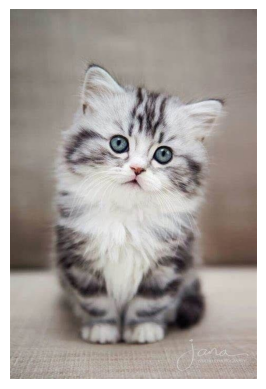

In [ ]:
img = Image.open(image_file)  # Replace "your_image.jpg" with your image file name or path
print(f"Image format: {img.format}, size: {img.size}, mode: {img.mode}")

# if the image is too large, you can crop it:
# img = img.crop((0, 0, 300, 300)) # format: (left,upper,right,lower)
# print(f"Image format: {img.format}, size: {img.size}, mode: {img.mode} (after cropping)")

plt.imshow(img)
plt.axis('off')
plt.show()

### Task 3: save the image as a file
Using PILLOW and the `.save( )` method, save your image in a few different formats.  Try saving it as a JPEG as well as a PNG. You can play with the quality levels, or whether PNG does compression/optimization.

**Deliverable**
- Save the image as a PNG file with no compression. This is your baseline file size for the raw image. Then save it in a format that does lossy compression (like JPEG or WEBP), with as much compression as you can stand until the image starts to noticeably degrade.  **Write down the ratio of the large file size to the small file size.**

In [ ]:
# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#jpeg
# Save as JPEG with a specific quality level
# quality is on a scale from 0 (worst) to 95 (best), or the string keep. The default is 75. Values above 95 should be avoided
img.save("image_smallest.jpg", quality=50)
img.save("image_small.jpg", quality=80)

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#png
# Can also set `compress_level` between 0 and 9 for ZLIB compression, default is 6
#   Automatically a 9 if `optimize=True`
img.save("image_biggest.png", optimize=False, compress_level=0)
img.save("image_big.png", optimize=True)

# https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#webp
img.save("image_small.webp", method=6, quality=50)

In [ ]:
mx, mn = 0, np.inf
# for file in glob.glob('*.png') + glob.glob('*.jpg'):
for file in glob.glob('image_*'):
    sz_kb = os.path.getsize(file)/1024
    mx = max(mx, sz_kb)
    mn = min(mn, sz_kb)
    print(f"The size of '{file:20s}' is {sz_kb:.1f} kB")
print(f'Biggest file is {mx:.1f} kB, smallest is {mn:.1f}, ratio is {mx/mn:.1f} x')

The size of 'image_biggest.png   ' is 988.4 kB
The size of 'image_small.jpg     ' is 36.6 kB
The size of 'image_big.png       ' is 284.6 kB
The size of 'image_small.webp    ' is 14.0 kB
The size of 'image_smallest.jpg  ' is 25.2 kB
Biggest file is 988.4 kB, smallest is 14.0, ratio is 70.6 x


#### Task 4: start working with the DFT
First, convert it to a grayscale image

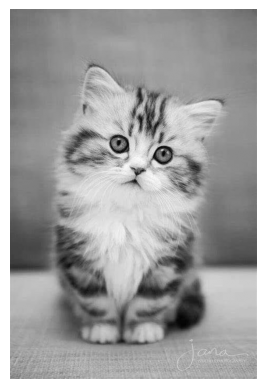

((474, 711), (711, 474))

In [ ]:
# To simplify things, we'll work with a grayscale image
X = np.array(img.convert('L'), dtype=float)
plt.imshow(X, cmap='gray')
plt.axis('off')
plt.show()
# And be careful, different conventions on size
img.size, X.shape # a PIL image is horizontal by vertical, but as a matrix, vertical means rows

Then plot the (sorted) absolute values of the 2D Fourier coefficients (after reshaping them to a vector instead of oa matrix)

Use `fft2` to get Fourier coefficients, or use `rfft2` which is like `fft2` but specialized for when the input is real-valued (as it is for our case) so it only returns half the Fourier coefficients (since the other half can be deduced using conjugate symmetry)

Use either `ravel()` or `flatten()` to reshape the matrix to a vector for sorting and plotting

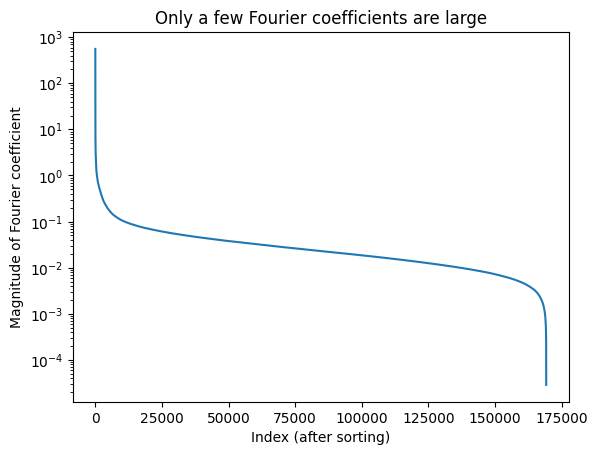

In [ ]:
Xhat = np.abs(fft.rfft2(X))/norm(X)
plt.semilogy( np.sort(Xhat.ravel())[::-1], '-' )
plt.ylabel('Magnitude of Fourier coefficient')
plt.xlabel('Index (after sorting)')
plt.title('Only a few Fourier coefficients are large')
plt.show()

Let's also make an image plot of the 2D DFT coefficients (so this time we won't flatten the matrix into a vector)

In [ ]:
def Fancy_2D_Fourier_Coefficient_Plot( Xhat ):
    """ Plots log|Xhat| of 2D Fourier coefficients
    and shifts the 0 frequency to the center, and tries
    to make nice axis labels and a colorbar """
    plt.imshow(fft.fftshift(np.log10(np.abs(Xhat))))
    plt.colorbar()
    xFreqs = fft.fftshift( fft.fftfreq( X.shape[1] ) )
    yFreqs = fft.fftshift( fft.fftfreq( X.shape[0] ) )
    xTicks = np.linspace(0,X.shape[1]-1,5,dtype=int)
    yTicks = np.linspace(0,X.shape[0]-1,7,dtype=int)
    plt.xticks(xTicks, [f'{lb:.2f}' for lb in xFreqs[xTicks]] )
    plt.yticks(yTicks, [f'{lb:.2f}' for lb in yFreqs[yTicks]] )
    plt.xlabel('Frequency in x')
    plt.ylabel('Frequency in y')
    plt.title('Low frequency in center of plot')
    plt.show()

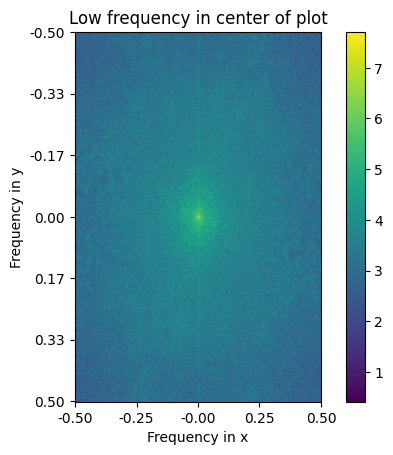

In [ ]:
Xhat = fft.fft2(X)
Fancy_2D_Fourier_Coefficient_Plot( Xhat )


#### Task 5: apply some masks to the 2D DFT coefficients
By "mask", we mean a matrix that is 0's and 1's. Where the mask matrix is 1, we keep the entries of the 2D DFT cooefficients, and where the mask matrix is 0, we set the 2D DFT cooefficients to zero.

Below, we show how to setup a mask matrix and then choose a mask that keeps only some low frequency components.

Your job is to choose a few different masks:
- You could also keep only low frequency, but only **very low** frequencies. At what point does the image quality degrade
- What if you kept only high frequencies!?
- What if you kept all frequencies in the x axis, but only some low frequencies in y?

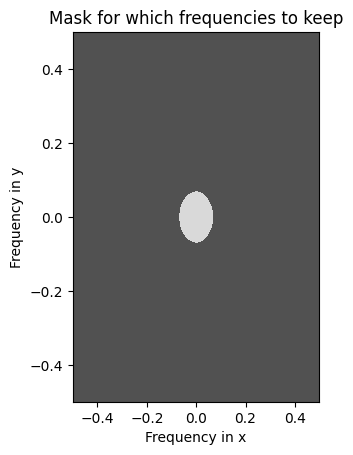

In [ ]:
# Try some masks
xFreqs = fft.fftshift( fft.fftfreq( X.shape[1] ) )
yFreqs = fft.fftshift( fft.fftfreq( X.shape[0] ) )

freq_x, freq_y = np.meshgrid(xFreqs, yFreqs)

# Define your mask:
# mask = (np.abs(freq_x) < .1) & (np.abs(freq_y) < 0.1)
# mask = freq_x**2 + freq_y**2 < .005 # starting to look warped
# mask = np.abs(freq_x) < .01  # this one is interesting
mask = freq_x**2 + freq_y**2 > .005 # keep only *high* frequencies!



fig, ax = plt.subplots()
plt.contourf( freq_x, freq_y, mask, cmap='Grays' )
ax.set_aspect(X.shape[0]/X.shape[1])
plt.xlabel('Frequency in x')
plt.ylabel('Frequency in y')
plt.title('Mask for which frequencies to keep')
plt.show()

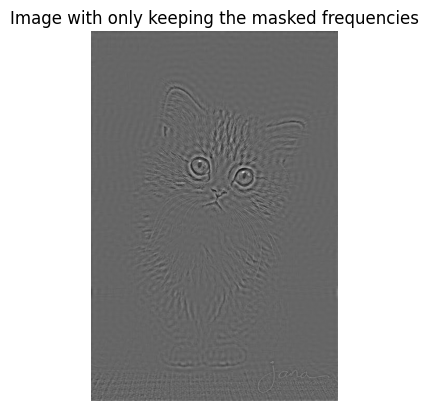

In [ ]:
Xhat_shifted = fft.fftshift(Xhat)
Xhat_shifted[~mask] = 0
X_est = np.real_if_close( fft.ifft2(fft.ifftshift(Xhat_shifted)) )
plt.imshow(X_est.real, cmap='gray')
plt.axis('off')
plt.title('Image with only keeping the masked frequencies')
plt.show()

## Part 3 (just for fun): is the magnitude or phase of the coefficients "more important"?

Image A is of size (474, 711)
Image A is of size (400, 400) after cropping


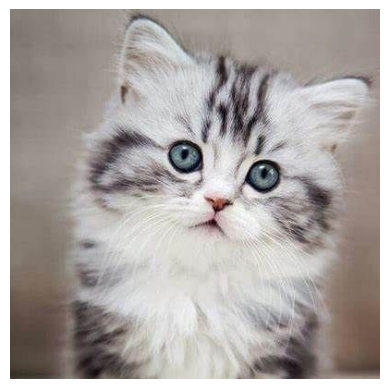

Image B is of size (1000, 667)
Image B is of size (400, 400) after cropping and scaling


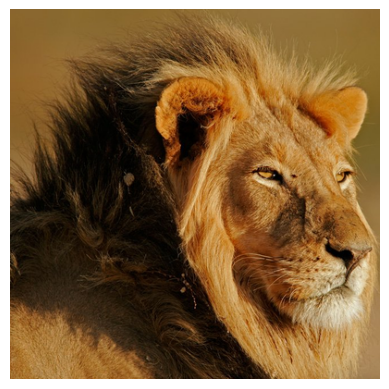

In [ ]:
# Our Fourier coefficients are complex, so they have a real and imaginary part
# Another way to think about complex numbers is via Magnitude and Phase

image_url = "https://i.pinimg.com/564x/1f/e3/78/1fe3783223df6554e790313a582097c8.jpg" # Replace with your image URL
response = requests.get(image_url)
response.raise_for_status() # Raise an exception for bad status codes
image_file = BytesIO(response.content)
img_A = Image.open(image_file)
print('Image A is of size', img_A.size )
img_A = img_A.crop((20, 100, 420, 500)) # format: (left,upper,right,lower)
print('Image A is of size', img_A.size, 'after cropping')
plt.imshow(img_A)
plt.axis('off')
plt.show()

image_url = "https://animalfactguide.com/wp-content/uploads/2020/12/lion.jpg"
response = requests.get(image_url)
response.raise_for_status() # Raise an exception for bad status codes
image_file = BytesIO(response.content)
img_B = Image.open(image_file)
print('Image B is of size', img_B.size )
img_B = img_B.crop((70, 0, 720, 650)) # format: (left,upper,right,lower)
img_B = img_B.resize(img_A.size, Image.LANCZOS)
print('Image B is of size', img_B.size, 'after cropping and scaling')
plt.imshow(img_B)
plt.axis('off')
plt.show()

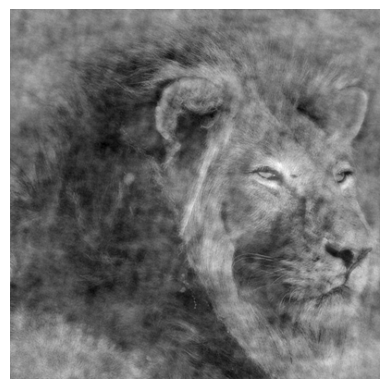

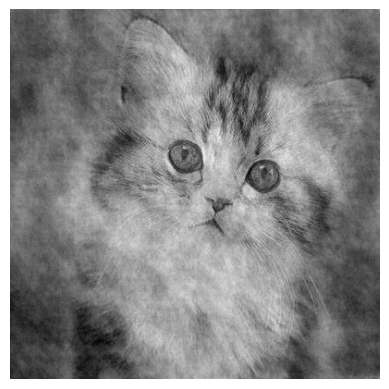

In [ ]:
# To simplify things, we'll work with a grayscale image
X_A = np.array(img_A.convert('L'), dtype=float)
X_B = np.array(img_B.convert('L'), dtype=float)

F_A = fft.rfft2(X_A)
F_B = fft.rfft2(X_B)

# Let's keep magnitude but swap phase in the Fourier domain, the invert back to image domain
F_A_mag, F_A_phase = np.abs(F_A), np.angle(F_A)
F_B_mag, F_B_phase = np.abs(F_B), np.angle(F_B)

F_A = F_A_mag*np.exp(1j*F_B_phase)
F_B = F_B_mag*np.exp(1j*F_A_phase)

X_A_est = fft.irfft2(F_A)
X_B_est = fft.irfft2(F_B)

plt.imshow( X_A_est, cmap='gray' )
plt.axis('off')
plt.show()
plt.imshow( X_B_est, cmap='gray' )
plt.axis('off')
plt.show()

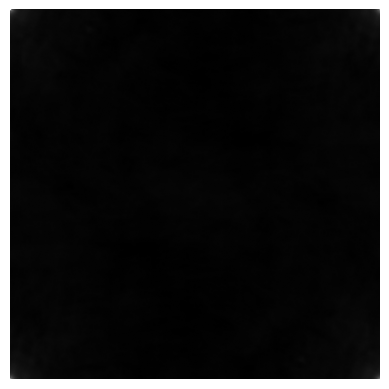

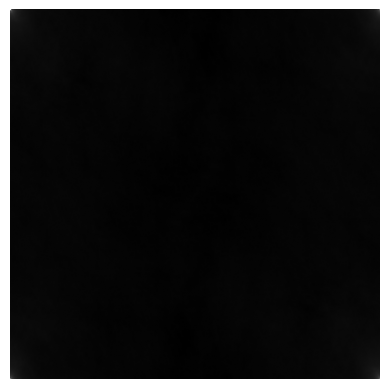

In [ ]:
# What if we remove phase altogether?

F_A = F_A_mag
F_B = F_B_mag

X_A_est = fft.irfft2(F_A)
X_B_est = fft.irfft2(F_B)

plt.imshow( X_A_est, cmap='gray' )
plt.axis('off')
plt.show()
plt.imshow( X_B_est, cmap='gray' )
plt.axis('off')
plt.show()

## Part 4 (just for fun)
We can look at the computational cost of the FFT

In [ ]:
import scipy.fft
import time

num_cores = os.cpu_count() # on colab, not very many, but likely more on your own computer

nList = np.array([512,1024,2048])
# the FFT doesn't need the size to be a power of 2 in order to have O(n log n) scaling,
# but it is fastest in that case

time_naive, time_fft = [], []
for n in nList:
    DFT_matrix = scipy.fft.fft(np.eye(n), workers=num_cores )

    x = np.random.randn(n)
    start = time.perf_counter()
    xhat = DFT_matrix @ x
    time_naive.append( time.perf_counter() - start )

    start = time.perf_counter()
    xhat = scipy.fft.fft(x,workers=num_cores)
    time_fft.append( time.perf_counter() - start )

print(time_naive)
print(time_fft)

[0.007663458000024548, 0.00126875200004406, 0.005062334000001556]
[0.00013422099999615966, 0.00011258299997507493, 0.00013663000004271453]


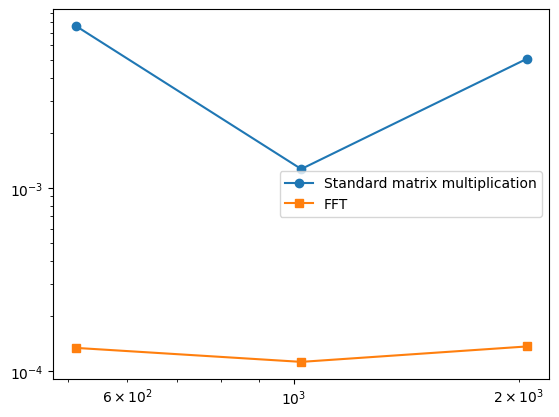

In [ ]:
plt.loglog( nList, time_naive, 'o-', label='Standard matrix multiplication')
plt.loglog( nList, time_fft, 's-', label='FFT')
plt.legend()
plt.show()

In [ ]:
nList = np.array([2])**np.arange(9,22,dtype=int)
# the FFT doesn't need the size to be a power of 2 in order to have O(n log n) scaling,
# but it is fastest in that case

time_power2, time_notpower2 = [], []
for n in nList:

    x = np.random.randn(n+1)  # n+1 data points
    start = time.perf_counter()
    # take fft of first n data points
    xhat = scipy.fft.fft(x[:-1],workers=num_cores)
    time_power2.append( time.perf_counter() - start )

    start = time.perf_counter()
    # take fft of all n+1 data points
    xhat = scipy.fft.fft(x[:-1],workers=num_cores)
    time_notpower2.append( time.perf_counter() - start )

print(time_power2)
print(time_notpower2)

[0.00017509899771539494, 4.497900226851925e-05, 6.943199696252123e-05, 0.0003451100055826828, 0.0002737240065471269, 0.000415269001678098, 0.0008980140046332963, 0.0028967429971089587, 0.006403024999599438, 0.009318270000221673, 0.03227976099879015, 0.0711964270012686, 0.15073581500473665]
[4.2134000977966934e-05, 4.661999992094934e-05, 7.761199958622456e-05, 0.00011875800555571914, 0.00020030000450788066, 0.0004785109995282255, 0.0009570530019118451, 0.002340174003620632, 0.004443944002559874, 0.009076160000404343, 0.02669026000512531, 0.05558504600048764, 0.12690030699741328]


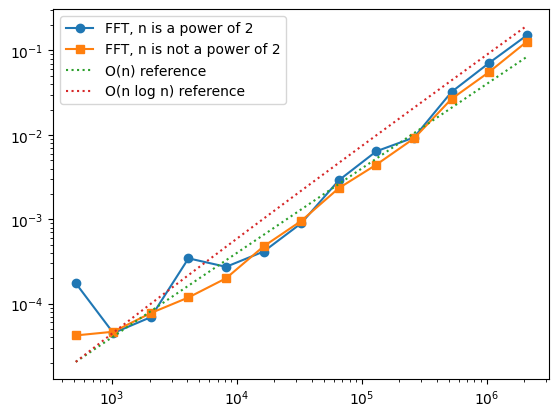

In [ ]:
plt.loglog( nList, time_power2, 'o-', label='FFT, n is a power of 2')
plt.loglog( nList, time_notpower2, 's-', label='FFT, n is not a power of 2')
plt.loglog( nList, .4e-7*nList, ':', label='O(n) reference')
plt.loglog( nList, .4e-7/9*nList*np.log2(nList), ':', label='O(n log n) reference')
plt.legend()
plt.show()

There's little difference in runtime (based on whether $n$ is a power of 2) for good FFT code thanks to decades of effort.

We also see that it's hard to distinguish $O(n)$ from $O(n\log n)$... which is good! It means $O(n \log n)$ is fast.